In [1]:
import numpy as np
import pandas as pd
import json

In [2]:
# Libraries that we cannot import for trading
import collections
import matplotlib.pyplot as plt
import re

import seaborn as sns
from IPython.display import display

In [3]:
SYMBOLS = ['COCONUTS','PINA_COLADAS']

# DATA LOADING

In [4]:
def split_data_by_symbol(df):
    markets = dict()
    df_grouped = df.groupby("symbol")
    symbols = list(df_grouped.groups.keys())
    for s in SYMBOLS:
        if s in df_grouped.groups:
            markets[s] = df_grouped.get_group(s).reset_index(drop=True)
    return markets

def load_hist_quote_data(files):
    md = [pd.read_csv(f,sep=';') for f in files]
    md = pd.concat(md, ignore_index=True)
    md.drop(columns=['profit_and_loss'], inplace=True)
    rename_columns = {'product':'symbol', 'bid_price_1': 'bid', 'ask_price_1': 'ask', 
                      'bid_volume_1':'bid_sz', 'ask_volume_1': 'ask_sz', 
                      'bid_price_2':'bid_2','bid_volume_2':'bid_sz_2','ask_price_2':'ask_2','ask_volume_2':'ask_sz_2',
                      'bid_price_3':'bid_3','bid_volume_3':'bid_sz_3','ask_price_3':'ask_3','ask_volume_3':'ask_sz_3'}
    md.rename(columns=rename_columns, inplace=True)

    md['timestamp'] = md['timestamp'] + 1000000*md['day'] - 1000000*(md['day'].min())
    markets = split_data_by_symbol(md)
    symbols = list(markets.keys())
    return markets


def load_hist_trade_data(files, hist_days):
    md = [pd.read_csv(f,sep=';') for f in files]
    for i in range(len(hist_days)):
        md[i]['day'] = hist_days[i]
    md = pd.concat(md, ignore_index=True)
    md.drop(columns=['currency'], inplace=True)
    md = md[md.price > 0].copy()
    md['timestamp'] = md['timestamp'] + 1000000*md['day'] - 1000000*(md['day'].min())
    
    markets = split_data_by_symbol(md)
    symbols = list(markets.keys())
    return markets

def augment_trade_data(trades):
    """ Making a guess to the sides of the trades based distance to mid price of previous quote
    Experimental - NOT SURE IF THIS IS GOING TO BE HELPFUL
    """
    bid_dist = trades['price'] - trades['bid']
    ask_dist = trades['ask'] - trades['price']
    trades['side'] = np.sign(bid_dist-ask_dist)
    return

def combine_hist_quote_trades(hist_quotes, hist_trades):
    """ Join data frames together
    """
    for sym in SYMBOLS:
        if not sym in hist_trades:
            continue
        quotes = hist_quotes[sym]
        trades = hist_trades[sym]
        # Join quote data to trades
        trades = trades.merge(quotes, how='left', on=['symbol','day','timestamp'])
        trades['notional'] = trades['price']*trades['quantity']

        augment_trade_data(trades)
        trades['buy_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 1 else 0, axis=1)
        trades['sell_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == -1 else 0, axis=1)
        trades['grey_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 0 else 0, axis=1)
        
        # Summarize state by state trade data
        trades_grp = trades.groupby(['symbol','day','timestamp']).agg({
            'quantity':'sum', 'notional':'sum', 'buy_vol':'sum', 'sell_vol':'sum','grey_vol':'sum'})
        
        trades_grp['vwap'] = trades_grp['notional']/trades_grp['quantity']
        trades_grp['trades'] = trades.groupby(['symbol','day','timestamp']).size()
        trades_grp = trades_grp.rename(columns={'quantity':'volume'})
        
        # Join trade data to quote
        quotes = quotes.merge(trades_grp.reset_index(), how='left')
        for col in ['volume', 'notional','trades', 'buy_vol','sell_vol','grey_vol']:
            quotes[col].fillna(0, inplace=True)
        quotes['vwap'].fillna(method='ffill',inplace=True)
        quotes.loc[quotes.vwap.isna(), 'vwap'] = quotes.loc[quotes.vwap.isna(), 'mid_price']
        
        # Update
        hist_quotes[sym] = quotes
        hist_trades[sym] = trades.copy()
    
    return hist_quotes, hist_trades

def load_hist_data(quote_files, trade_files, hist_days):
    hist_quotes = load_hist_quote_data(quote_files)
    hist_trades = load_hist_trade_data(trade_files, hist_days)
    
    hist_quotes, hist_trades = combine_hist_quote_trades(hist_quotes, hist_trades)
    return hist_quotes, hist_trades

In [5]:
def quote_levels_feature(quote):
    quote['bid_levels'] = 1
    quote['ask_levels'] = 1
    
    for i in range(2,4):
        quote.loc[quote[f'bid_{i}'].notna(), 'bid_levels'] += 1
        quote.loc[quote[f'ask_{i}'].notna(), 'ask_levels'] += 1
    
    return

def quote_weighted_px_full(quote, levels=5):
    notional = quote.bid_sz*quote.bid + quote.ask_sz*quote.ask
    size = quote.bid_sz + quote.ask_sz
    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size


def quote_weighted_px_square(quote, levels=5):
    notional, size = 0, 0
    for x in ['bid','ask']:
        notional += np.square(quote[f'{x}_sz'])*quote[x]
        size += np.square(quote[f'{x}_sz'])
   
        for i in range(2, min(quote[f'{x}_levels'], levels)+1):
            notional += quote[f'{x}_{i}']*np.square(quote[f'{x}_sz_{i}'])
            size += np.square(quote[f'{x}_sz_{i}'])
    
    return notional/size

def quote_weighted_px_skip_top(quote, levels=5):
    notional, size = 0, 0
    
    if quote['bid_sz'] >= 5:
        notional += quote.bid_sz*quote.bid
        size += quote.bid_sz
    if quote['ask_sz'] >= 5:
        notional += quote.ask_sz*quote.ask
        size += quote.ask_sz

    for i in range(2, min(quote['bid_levels'], levels)+1):
        notional += quote[f'bid_{i}']*quote[f'bid_sz_{i}']
        size += quote[f'bid_sz_{i}']
    for i in range(2, min(quote['ask_levels'], levels)+1):
        notional += quote[f'ask_{i}']*quote[f'ask_sz_{i}']
        size += quote[f'ask_sz_{i}']
    
    return notional/size

In [13]:
MOVING_WINDOW_TIMES = [5, 10, 25, 50]
HIST_PX_TIMES = [1, 5, 10, 20, 30, 50]
FUTURE_TIMES = [1, 2, 3, 4, 5, 10, 25, 50, 100, 200, 500]

def quote_preprocess(md):
    """ Pre-computing additional columns for analyzing quote
    """
    # md['mid_price'] = (md.ask_price_1 + md.bid_price_1)/2
    if 'bid_levels' not in md.columns:
        quote_levels_feature(md)
    md['spread'] = md.ask - md.bid
    md['return'] = md['mid_price']/md['mid_price'].iloc[0] # % change in price since the beginning
    
#     for t in MOVING_WINDOW_TIMES:
#         md[f'mid_px_mavg{t}'] = md['mid_price'].rolling(t, min_periods=0).mean()
#         md[f'mid_px_mavg{t}_norm'] = md[f'mid_px_mavg{t}']/md['mid_price']
#         md[f'px_norm_mavg{t}'] = md['return'].rolling(t, min_periods=0).mean()
        
    # quote weighted average price
    quote_sz = md.bid_sz + md.ask_sz
    md['quote_wgt_px_top'] = (md.bid_sz*md.bid + md.ask_sz*md.ask)/quote_sz
    md['fair_v1'] = md.apply(quote_weighted_px_full, axis=1)
    md['fair_v2'] = md['vwap']
    md['fair_v3'] = md.apply(quote_weighted_px_square, axis=1)
    
#     for t in HIST_PX_TIMES:
#         # Price move since the past
#         md[f'px_move_{t}'] = md.mid_price-md.mid_price.shift(t)
#         md[f'bid_move_{t}'] = md.bid-md.bid.shift(t)
#         md[f'ask_move_{t}'] = md.ask-md.ask.shift(t)
        
#         md[f'px_move_{t}'].fillna(0, inplace=True)
#         md[f'bid_move_{t}'].fillna(0, inplace=True)
#         md[f'ask_move_{t}'].fillna(0, inplace=True)
        
#         md[f'px_move_{t}_norm'] = md[f'px_move_{t}']/md['mid_price']
        
#         # log return
#         md[f'log_return_{t}'] = np.log(md.mid_price)-np.log(md.mid_price.shift(t))
#         md[f'log_return_{t}'].fillna(1, inplace=True)
#     md = md.copy()
    
    # Volume    
    for t in MOVING_WINDOW_TIMES:
        md[f'volume_{t}'] = md['volume'].rolling(t, min_periods=0).sum()
    if 'buy_vol' in md.columns:
        for t in MOVING_WINDOW_TIMES:
            md[f'buy_vol_{t}'] = md['buy_vol'].rolling(t, min_periods=0).sum()
            md[f'sell_vol_{t}'] = md['sell_vol'].rolling(t, min_periods=0).sum()
        md['volume_imb'] = md.buy_vol-md.sell_vol # Positive implies people are preparing for quote to move in
        
    md = md.copy()

    md['quote_imb'] = md.bid_sz/quote_sz
    md['levels_imb'] = md.bid_levels-md.ask_levels # Positive implies people are preparing for quote to move in
    
    ############# Future
    get_quote_stats(md)
    md = md.copy()
    get_quote_tick_change(md)
    md['fvolume'] = md['volume'].shift(-1)
    for t in MOVING_WINDOW_TIMES:
        md[f'fvolume_{t}'] = md[f'volume_{t}'].shift(-t)
    md = md.copy()
        
    # Features
    md['total_bid_sz'] = md[['bid_sz','bid_sz_2','bid_sz_3']].sum(axis=1)
    md['total_ask_sz'] = md[['ask_sz','ask_sz_2','ask_sz_3']].sum(axis=1)
    # md['max_bid_sz'] = md[['bid_sz','bid_sz_2','bid_sz_3']].max(axis=1)
    # md['max_ask_sz'] = md[['ask_sz','ask_sz_2','ask_sz_3']].max(axis=1)
    
#     md['bid_sz_mavg'] = md['bid_sz'].cumsum()/(1+md['timestamp']/100)
#     md['ask_sz_mavg'] = md['ask_sz'].cumsum()/(1+md['timestamp']/100)
       
    for v in [1, 2, 3]:
        md[f'dist_fair_v{v}'] = md[f'fair_v{v}']-md['mid_price']
        md[f'dist_fair_v{v}_norm'] = md[f'dist_fair_v{v}']/md['mid_price']
        
        md[f'dist_fair_v{v}_bid'] = md[f'fair_v{v}']-md['bid'] # expected to be positive
        md[f'dist_fair_v{v}_ask'] = md[f'fair_v{v}']-md['ask'] # expected to be negative
        for t in HIST_PX_TIMES:
            md[f'fair_v{v}_move_{t}'] = md[f'fair_v{v}']-md[f'fair_v{v}'].shift(t)
    
    return md

def get_quote_tick_change(md):
    md['bid_improve'] = md['bid'] > md['bid'].shift(1)
    md['bid_revert'] = md['bid'] < md['bid'].shift(1)
    md['ask_improve'] = md['ask'] < md['ask'].shift(1)
    md['ask_revert'] = md['ask'] > md['ask'].shift(1)
    
    return

def get_quote_stats(md):
    # Future prices
    for t in FUTURE_TIMES:
        # Future - present
        # Mid to mid, bid to mid, ask to mid
        md[f'fpx_{t}'] = md.mid_price.shift(-t).fillna(method='ffill') - md.mid_price
        md[f'fpx_bid_{t}'] = md.bid.shift(-t).fillna(method='ffill') - md.bid
        md[f'fpx_ask_{t}'] = md.ask.shift(-t).fillna(method='ffill') - md.ask
    for t in FUTURE_TIMES:
        md[f'fpx_move_{t}'] = np.sign(md[f'fpx_{t}'])
        md[f'fpx_bid_move_{t}'] = md[f'fpx_bid_{t}'] > 0
        md[f'fpx_ask_move_{t}'] = md[f'fpx_ask_{t}'] <= 0
    
    return

def basic_quote_analysis(md):
    md = md.copy()
    if 'bid_levels' not in md.columns:
        quote_levels_feature(md)
    md['spread'] = md.ask - md.bid
    quote_sz = md.bid_sz + md.ask_sz
    md['quote_imb'] = md.bid_sz/quote_sz
    md['levels_imb'] = md.bid_levels-md.ask_levels # Positive implies people are preparing for quote to move in
    get_quote_stats(md)
    get_quote_tick_change(md)
    
    return md.copy()

In [7]:
def hist_data_summary(hist_quotes, hist_trades):
    for sym in SYMBOLS:
        print(sym)
        quote = hist_quotes[sym]
        quote_summary = quote.agg({
            'spread':['mean','std'], 'mid_price': ['mean','std'], 
            # 'fpx_move_10': ['mean','std'], 'px_move_50': ['mean','std'],
            'volume':['sum', 'mean'], 'trades':['sum', 'mean'],
            'bid_sz': 'mean', 'ask_sz':'mean', 
            'bid_levels':'mean', 'ask_levels':'mean',
            'bid_sz_2':'mean', 'ask_sz_2':'mean',
            'bid_sz_3':'mean', 'ask_sz_3':'mean',
        }).round(2)
        display(quote_summary)
        
fig_size = (6,3)

def plot_col_sym(md, sym, col):
    f, ax = plt.subplots(figsize=fig_size)
    ax.plot("timestamp", col, data=md)
    ax.set_xlabel("Time")
    ax.set_ylabel(col)
    ax.set_title(sym)
    plt.tight_layout()
    return

In [61]:
def read_trading_logs(file):
    # Load in jsons for trading states and sent orders
    state_regex = re.compile(r"(\d+) (\{.*\})$")
    orders_regex = re.compile(r"(\d+) SENT_ORDERS (\{.*\})")

    trading_states = []
    sent_orders = []
    with open(file, "r") as fp:
        lines = fp.readlines()
        for l in lines:
            match = state_regex.match(l)
            if match:
                trading_states.append(match.group(2))
                continue
            match = orders_regex.match(l)
            if match:
                sent = json.loads(match.group(2))
                sent['timestamp'] = int(match.group(1))
                sent_orders.append(sent)
                continue
        
    return trading_states, sent_orders

def process_trading_state_jsons(trading_states):
    positions = []
    market_trades = []
    latest_trade_timestamp = collections.defaultdict(int)
    own_trades = []
    order_depths = []
    observations = []
    
    listings = json.loads(trading_states[0])["listings"]
    for l in listings:
        # Dummy position
        positions.append({"timestamp": 0, "symbol": l, "position": 0})
    
    for t in trading_states:
        state = json.loads(t)
        if type(state) == int:
            insert_empty_state(state, listings, positions)
        else:
            extract_position(positions, state)
            extract_new_trades(market_trades, latest_trade_timestamp, state)
            extract_own_trades(own_trades, state)
            extract_order_book(order_depths, state)
            extract_observations(observations, state)
            
    positions = pd.DataFrame(positions)
    observations = pd.DataFrame(observations)
    
    market_trades = pd.DataFrame(market_trades)
    if len(own_trades) == 0:
        own_trades.append({"timestamp": -1, "symbol": l, "price": np.nan, "quantity": 0, "buyer": "DUMMY", "seller": 0})
    own_trades = pd.DataFrame(own_trades)
    order_depths = pd.DataFrame(order_depths)
    
    return positions, market_trades, own_trades, order_depths, observations

def insert_empty_state(timestamp, listings, *args):
    # Insert timestamp corresponding to the empty state - these are to be forward filled
    for data in args:
        for l in listings:
            data.append({"timestamp": timestamp, "symbol": l})
    return

def extract_position(positions, state):
    pos = state['position']
    for p in pos:
        positions.append({"timestamp": state['timestamp'], "symbol": p, "position": pos[p]})
    for p in SYMBOLS:
        if p not in pos:
            positions.append({"timestamp": state['timestamp'], "symbol": p, "position": 0})
    return

def extract_observations(observations, state):
    obs = state['observations']
    for p in obs:
        observations.append({"timestamp": state['timestamp'], "symbol": p, "observation": obs[p]})
        
    return

def extract_new_trades(market_trades, latest_trade_timestamp, state):
    time = state['timestamp']
    for sym in state['market_trades']:
        for t in state['market_trades'][sym]:
            if t['timestamp'] == time-100:
                market_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    return

def extract_own_trades(own_trades, state):
    time = state['timestamp']
    for sym in state['own_trades']:
        for t in state['own_trades'][sym]:
            if t['timestamp'] == time-100:
                own_trades.append(t)
            elif t['timestamp'] == time:
                print("Found same timestamp trade")
    return

def extract_order_book(order_depths, state):
    time = state['timestamp']
    for sym in state['order_depths']:
        quote = create_quote(time, sym, state['order_depths'][sym])
        order_depths.append(quote)
    return


def create_quote(time, sym, order_depths):
    quote = {'timestamp': time, 'symbol': sym}
    
    # Buy quotes
    quote['bid_levels'] = len(order_depths['buy_orders'])
    for i, px in enumerate(sorted(order_depths['buy_orders'], key=lambda x: float(x), reverse=True)):
        # Highest to lowest
        if i >= 3:
            break
        quote[f'bid_{i+1}'] = float(px)
        quote[f'bid_sz_{i+1}'] = order_depths["buy_orders"][px]
    for i in range(3, 1, -1):
        if f'bid_{i}' in quote:
            break
        else:
            quote[f'bid_{i}'] = np.nan
            quote[f'bid_sz_{i}'] = np.nan
    
    # Sell quotes
    quote['ask_levels'] = len(order_depths['sell_orders'])
    for i, px in enumerate(sorted(order_depths['sell_orders'], key=lambda x: float(x))):
        if i >= 3:
            break
        quote[f'ask_{i+1}'] = float(px)
        quote[f'ask_sz_{i+1}'] = np.abs(order_depths["sell_orders"][px])
    for i in range(3, 1, -1):
        if f'ask_{i}' in quote:
            break
        else:
            quote[f'ask_{i}'] = np.nan
            quote[f'ask_sz_{i}'] = np.nan
        
    return quote

def process_order_depths(order_depths):
    order_depths.rename(columns={'bid_1': 'bid', 'ask_1': 'ask', 'bid_sz_1': 'bid_sz', 'ask_sz_1': 'ask_sz'}, inplace=True)
    order_depths['mid_price'] = (order_depths['bid']+order_depths['ask'])/2
    nbbo = order_depths[['timestamp','symbol','bid','ask','bid_sz','ask_sz', 'mid_price']].copy()

    return nbbo

def process_market_trades(market_trades):
    """ Processing of dataframe for market_trades
    """
    market_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_own_trades(own_trades):
    """ Processing of dataframe for own_trades
    """ 
    # Side refers to side of algo
    own_trades['side'] = own_trades.apply(lambda x: 1 if x['buyer']=='Submission' else -1, axis=1)
    own_trades.drop(columns=['buyer', 'seller'], inplace=True)
    return

def process_sent_orders_json(sent_orders):
    if len(sent_orders) == 0:
        return pd.DataFrame(columns = ['symbol', 'timestamp', 'price', 'quantity', 'side'])
    df = []
    for t in sent_orders:
        time = t['timestamp']
        for s in t:
            if s != 'timestamp' and t[s]:
                for order in t[s]:
                    order['timestamp'] = time
                    df.append(order)
        
    df = pd.DataFrame(df)
    return df


def combine_quote_trades(quote, trades):
    # Aggregate timestamp data of trades
    trades['notional'] = trades['price']*trades['quantity']
    # trades['buy_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 1 else 0, axis=1)
    # trades['sell_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == -1 else 0, axis=1)
    # trades['grey_vol'] = trades.apply(lambda x: x['quantity'] if x['side'] == 0 else 0, axis=1)
    
    # Trades are aligned to happen after the order depth that we see in the market
    trades['timestamp'] = trades['timestamp'] + 100
    trades_grouped = trades.groupby(['symbol', 'timestamp']).agg({'quantity':'sum', 'notional':'sum'})
    trades_grouped['vwap'] = trades_grouped['notional']/trades_grouped['quantity']
    trades_grouped['trades'] = trades.groupby(['symbol', 'timestamp']).size()
    
    trades_grouped = trades_grouped.rename(columns={'quantity':'volume'})
    quote = quote.merge(trades_grouped.reset_index(), how='left')
    for col in ['volume', 'notional','trades']:
        quote[col].fillna(0, inplace=True)
    
    quote.loc[quote.vwap.isna(), 'vwap'] = quote.loc[quote.vwap.isna(), 'mid_price']
    return quote

def combine_quote_algo_trades(quote, trades):
    # Aggregate timestamp data of trades
    trades['notional'] = trades['price']*trades['quantity']
    
    # Trades are aligned to happen after the order depth that we see in the market
    trades['timestamp'] = trades['timestamp'] + 100
    trades_grouped = trades.groupby(['symbol', 'timestamp']).agg({'quantity':'sum', 'notional':'sum'})
    trades_grouped['trades'] = trades.groupby(['symbol', 'timestamp']).size()
    
    trades_grouped = trades_grouped.rename(columns={'quantity':'volume'})
    quote = quote.merge(trades_grouped.reset_index(), on=['symbol','timestamp'], how='left', suffixes=('','_algo'))
    
    for col in ['volume_algo', 'notional_algo', 'trades_algo']:
        quote[col].fillna(0, inplace=True)
    
    return quote

def fill_active(x):
    if x['side'] == 1:
        # Buy
        return x['price'] >= x['ask']
    else:
        return x['price'] <= x['bid']
    
def fix_fill_volume(x):
    fill_qty = np.clip(x['fill_qty']-x['quantity'].cumsum()-x['quantity'].iat[0], 0, None)
    return fill_qty

def combine_orders_fills(orders, fills):
    """ Combine orders sent with fills that the order got in the market
    """
    if orders.empty:
        return orders
    fills['active'] = fills.apply(fill_active, axis=1)

    gcols = ['symbol','timestamp','price','side']
    fill_data = fills.groupby(gcols)[['quantity']].sum()
    fill_data.reset_index(inplace=True)
    fill_data.rename(columns={'quantity': 'fill_qty'}, inplace=True)
    fill_data['i'] = 0
    orders['i'] = orders.groupby(gcols).cumcount()
    orders = orders.merge(fill_data, how='left', on=gcols+['i']).drop('i',axis=1)
    orders['fill_qty'].fillna(0, inplace=True)    
    orders['fill_pct'] = np.abs(orders['fill_qty']/orders['quantity'])
    
    return orders

# PnL, Position, Volume Traded, Notional Traded, VWAP
def trading_performance(positions, own_trades, quote):
    positions = positions.merge(quote[['timestamp','symbol','mid_price']], on=['symbol','timestamp']) # Add mid price
    own_trades['trades'] = 1
    own_trades['notional'] = own_trades['price']*own_trades['quantity']
    own_trades.rename(columns={'quantity':'qty'},inplace=True)
    vol_cols = []
    for col in ['qty','notional','trades']:
        own_trades[f'buy_{col}'] = own_trades[col]
        own_trades[f'sell_{col}'] = own_trades[col]
        own_trades.loc[own_trades['side'] == -1, f'buy_{col}'] = 0
        own_trades.loc[own_trades['side'] == 1, f'sell_{col}'] = 0
        vol_cols += [col, f'buy_{col}',f'sell_{col}']
    own_trades_g = own_trades.groupby(['symbol','timestamp'])[vol_cols].sum()

    positions = positions.merge(own_trades_g.reset_index(), how='left', on=['symbol','timestamp'])
    for col in vol_cols:
        positions[col].fillna(0, inplace=True)
        positions[f'total_{col}'] = positions.groupby('symbol')[col].transform(pd.Series.cumsum)
    positions['pnl'] = (positions['total_sell_notional']-positions['total_buy_notional']) \
            - positions['mid_price']*(positions['total_sell_qty']-positions['total_buy_qty'])

    positions = positions.copy()
    return positions

def load_data_from_log(file, by_symbol=True):
    trading_states, sent_orders = read_trading_logs(file)
    positions, market_trades, own_trades, order_depths, observations = process_trading_state_jsons(trading_states)
    quote = process_order_depths(order_depths)
    process_market_trades(market_trades)
    process_own_trades(own_trades)
    orders = process_sent_orders_json(sent_orders)
    
    # Joining actions to state
    market_trades = market_trades.merge(quote, how='left', on=['symbol','timestamp',])
    augment_trade_data(market_trades)
    
    own_trades = own_trades.merge(quote, how='left', on=['symbol','timestamp','symbol'])
    orders = orders.merge(quote, how='left', on=['symbol','timestamp'])
    orders = combine_orders_fills(orders, own_trades)
    
    quote = combine_quote_trades(quote, market_trades.copy())
    quote = combine_quote_algo_trades(quote, own_trades.copy())

    order_depths = combine_quote_trades(order_depths, market_trades.copy())
    order_depths = combine_quote_algo_trades(order_depths, own_trades.copy())
    
    positions = trading_performance(positions, own_trades.copy(), quote) 
    
    dfs = {}
    dfs['orders'] = orders
    dfs['positions'] = positions
    dfs['order_depths'] = order_depths
    dfs['quote'] = quote
    dfs['market_trades'] = market_trades
    dfs['own_trades'] = own_tradesc
    dfs['observations'] = observations
    
    if by_symbol:
        for table in dfs:
            if not dfs[table].empty:
                dfs[table] = split_data_by_symbol(dfs[table])    
    return dfs

def plot_intraday(dfs, col):
    f, ax = plt.subplots(figsize=fig_size)
    for product in dfs:
        ax.plot("timestamp", col, data=dfs[product], label=product)
    ax.set_xlabel("Time")
    ax.set_ylabel(col)
    ax.legend()
    plt.tight_layout()
    
    return

def trading_simulation_summary(dfs):
    total_pnl = 0
    for sym in SYMBOLS:
        trade_perf = dfs['positions'][sym].iloc[-1]
        pnl = trade_perf['pnl']
        total_pnl += pnl
        market_volume = dfs['market_trades'][sym]['quantity'].sum()
        trade_count = trade_perf['total_trades']
        trade_volume = trade_perf['total_qty']
        vol_per_step = dfs['positions'][sym]['qty'].mean()

        print("""{}: PnL={} | Trades={} | MarketVol={} | Volume Filled={} | POV={:.2} | Shares/Step={:.3} | PnL/Share={:.4}""".format(sym, \
            pnl, trade_count, market_volume, trade_volume,trade_volume/(market_volume+trade_volume), vol_per_step, pnl/trade_volume))
    print("Total PnL={}".format(total_pnl))
    plot_intraday(dfs['positions'], 'pnl')
    plot_intraday(dfs['positions'], 'position')
    
def algo_spread(x):
    bid = np.fmax(x['price_algo_buy'], x['bid'])
    ask = np.fmin(x['price_algo_sell'], x['ask'])
    return ask-bid

algo_market_cols = ['symbol', 'timestamp', 'price_algo_buy', 'price_algo_sell','algo_spread']
def get_algo_market(orders, quote):
    buy_orders = orders.loc[orders.side == 1].copy()
    sell_orders = orders.loc[orders.side == -1].copy()

    buy_spread = buy_orders.groupby(['symbol','timestamp','price']).agg({'quantity':'sum','fill_qty':'sum'}).reset_index()
    buy_spread.drop_duplicates(subset=['symbol','timestamp'], inplace=True, keep='last') # keep most aggressive
    sell_spread = sell_orders.groupby(['symbol','timestamp','price']).agg({'quantity':'sum','fill_qty':'sum'}).reset_index()
    sell_spread.drop_duplicates(subset=['symbol','timestamp'], inplace=True, keep='first')
    
    algo_market = buy_spread.merge(sell_spread, how='outer', on=['symbol','timestamp'], suffixes=['_algo_buy','_algo_sell'])
    algo_market.sort_values('timestamp',inplace=True)
    algo_market = algo_market.merge(quote, how='left', on=['symbol','timestamp'])
    algo_market['spread'] = algo_market['ask'] - algo_market['bid']
    algo_market['algo_spread'] = algo_market.apply(algo_spread, axis=1)
    
    return algo_market


def order_analysis(orders):
    orders['px_bid_dist'] = orders['price'] - orders['bid']
    orders['px_ask_dist'] = orders['price'] - orders['ask']
    orders['filled'] = orders['fill_qty'] > 0
    
    for t in FUTURE_TIMES:
        orders[f'toxicity_{t}'] = orders['side']*(orders[f'fpx_{t}']+orders['mid_price']-orders['price'])
        orders[f'pnl_{t}'] = orders['fill_qty']*orders[f'toxicity_{t}']
        orders[f'fill_revert_{t}'] = np.sign(orders[f'pnl_{t}'])
        orders[f'spread_capture_{t}'] = orders[f'toxicity_{t}']/orders['spread']
    
    return

toxicity_labels, reversion_labels = [], []
for t in FUTURE_TIMES:
    toxicity_labels.append(f'toxicity_{t}')
    reversion_labels.append(f'fill_revert_{t}')

def get_orders_fills(market_trades, orders, quote):
    algo_market = get_algo_market(orders, quote)

    orders_cols = ['note', 'price', 'quantity', 'side', 'symbol', 'timestamp','fill_qty', 'fill_pct']
    fills = orders.loc[orders.fill_qty > 0]
    fills = fills.merge(quote_preprocess(quote), how='left',on=['symbol','timestamp'], suffixes=('','_q'))
    order_analysis(fills)
    fills = fills.merge(algo_market[algo_market_cols], on=['symbol','timestamp'])

    missed_fills = orders.loc[orders.fill_pct < 1][orders_cols].merge(market_trades, on=['symbol','timestamp'], suffixes=('_algo','_mkt'))
    missed_fills = missed_fills.merge(quote_preprocess(quote), how='left',on=['symbol','timestamp'], suffixes=('','_q'))
    missed_fills = missed_fills.merge(algo_market[algo_market_cols], on=['symbol','timestamp'])
    
    return fills, missed_fills

## Load

In [14]:
quote_files, trade_files = [], []
data_dir = 'hist_data/island-data-bottle-round-2/'
hist_days = [-1, 0, 1]
quote_files += [f'{data_dir}prices_round_2_day_{i}.csv' for i in hist_days]
trade_files += [f'{data_dir}trades_round_2_day_{i}_wn.csv' for i in hist_days]

data_dir = 'hist_data/island-data-bottle-round-3/'
hist_days = [2]
quote_files += [f'{data_dir}prices_round_3_day_{i}.csv' for i in hist_days]
trade_files += [f'{data_dir}trades_round_3_day_{i}_wn.csv' for i in hist_days]

data_dir = 'hist_data/island-data-bottle-round-4/'
hist_days = [3]
quote_files += [f'{data_dir}prices_round_4_day_{i}.csv' for i in hist_days]
trade_files += [f'{data_dir}trades_round_4_day_{i}_wn.csv' for i in hist_days]

hist_quotes, hist_trades = load_hist_data(quote_files, trade_files, [-1,0,1,2, 3])
for sym in SYMBOLS:
    hist_quotes[sym] = basic_quote_analysis(hist_quotes[sym])

In [15]:
hist_data_summary(hist_quotes, hist_trades)

COCONUTS


,spread,mid_price,volume,trades,bid_sz,ask_sz,bid_levels,ask_levels,bid_sz_2,ask_sz_2,bid_sz_3,ask_sz_3
mean,2.47,7974.55,0.86,0.04,154.17,155.44,1.24,1.24,135.37,130.74,130.62,125.02
std,0.61,68.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,43132.00,1765.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


PINA_COLADAS


,spread,mid_price,volume,trades,bid_sz,ask_sz,bid_levels,ask_levels,bid_sz_2,ask_sz_2,bid_sz_3,ask_sz_3
mean,2.65,14956.42,0.28,0.03,71.35,71.49,1.35,1.35,64.93,64.45,62.76,62.65
std,0.59,115.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,NaN,13928.00,1373.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Historical Quote Analysis

COCONUTS
PINA_COLADAS


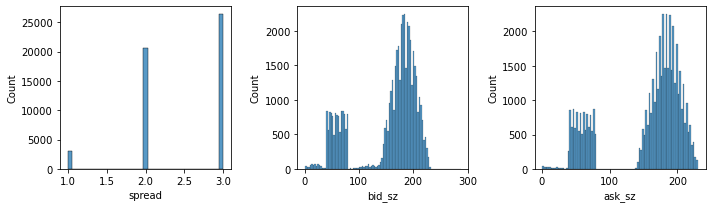

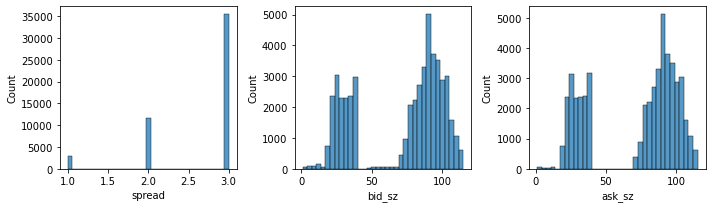

In [54]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    print(sym)
    f, ax = plt.subplots(1, 3, figsize=(10,3))
    for i, col in enumerate(['spread','bid_sz','ask_sz']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

COCONUTS
PINA_COLADAS


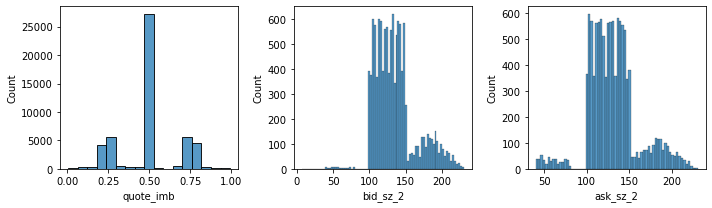

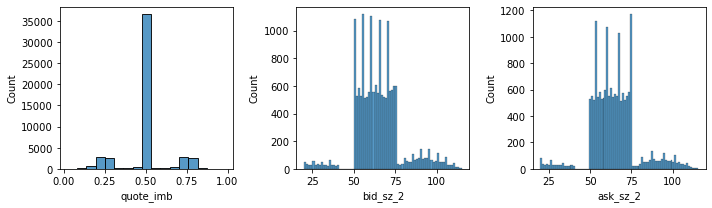

In [55]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    print(sym)
    f, ax = plt.subplots(1, 3, figsize=(10,3))
    for i, col in enumerate(['quote_imb','bid_sz_2','ask_sz_2']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

COCONUTS
PINA_COLADAS


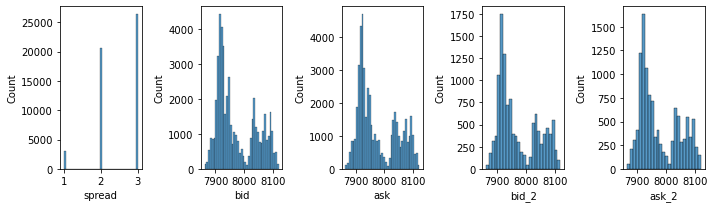

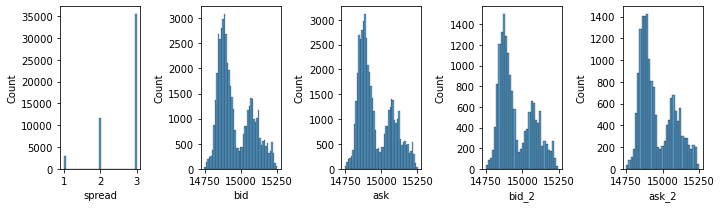

In [56]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    print(sym)
    f, ax = plt.subplots(1, 5, figsize=(10,3))
    for i, col in enumerate(['spread','bid','ask', 'bid_2','ask_2']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

COCONUTS
PINA_COLADAS


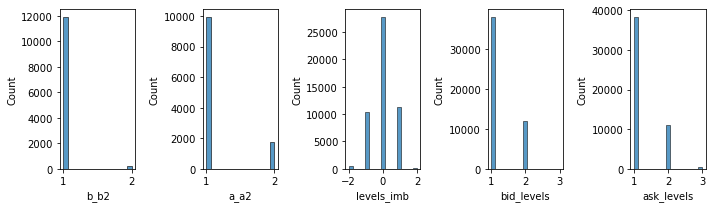

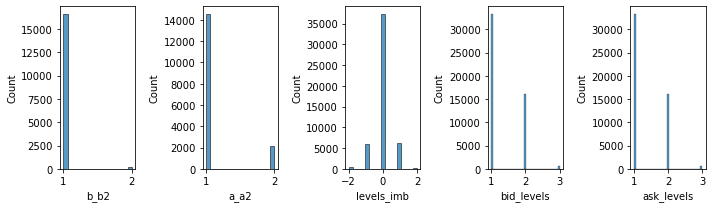

In [57]:
for sym in SYMBOLS:
    quote = hist_quotes[sym].copy()
    quote['b_b2'] = quote['bid'] - quote['bid_2']
    quote['a_a2'] = quote['ask_2'] - quote['ask']
    print(sym)
    f, ax = plt.subplots(1, 5, figsize=(10,3))
    for i, col in enumerate(['b_b2','a_a2','levels_imb', 'bid_levels', 'ask_levels']):
        sns.histplot(x=col, data=quote, ax=ax[i])
    plt.tight_layout()

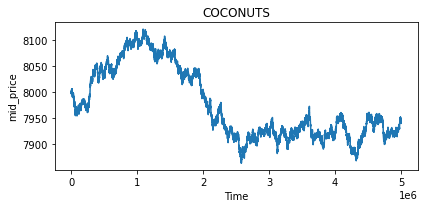

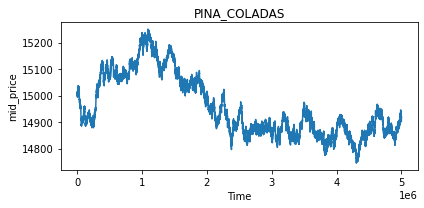

In [58]:
for sym in SYMBOLS:
    quote = hist_quotes[sym]
    plot_col_sym(quote, sym, 'mid_price')

# Historical Trade Analysis

In [123]:
summ = []
for sym in SYMBOLS:
    trades = hist_trades[sym]
    summ.append(trades['quantity'].describe().rename(sym))
pd.concat(summ,axis=1).transpose()

,count,mean,std,min,25%,50%,75%,max
COCONUTS,1765.0,24.437394,20.483115,1.0,8.0,14.0,44.0,79.0
PINA_COLADAS,1373.0,10.144210,9.220629,1.0,3.0,5.0,14.0,40.0


In [124]:
summ = []
for sym in SYMBOLS:
    trades = hist_trades[sym]
    summ.append(trades.groupby('timestamp')['quantity'].sum().describe().rename(sym))
pd.concat(summ,axis=1).transpose()

,count,mean,std,min,25%,50%,75%,max
COCONUTS,1623.0,26.575478,22.760650,5.0,8.0,15.0,47.0,80.0
PINA_COLADAS,1294.0,10.763524,10.145181,2.0,3.0,5.0,14.0,40.0


COCONUTS
PINA_COLADAS


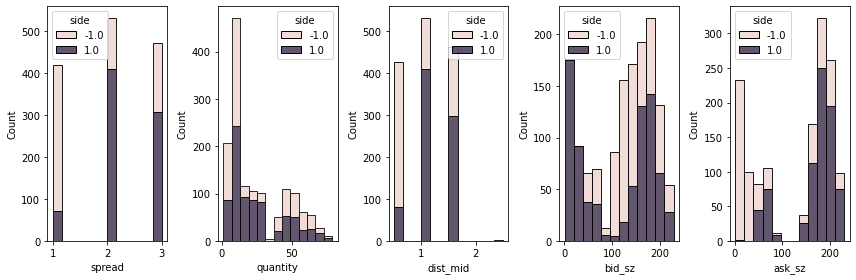

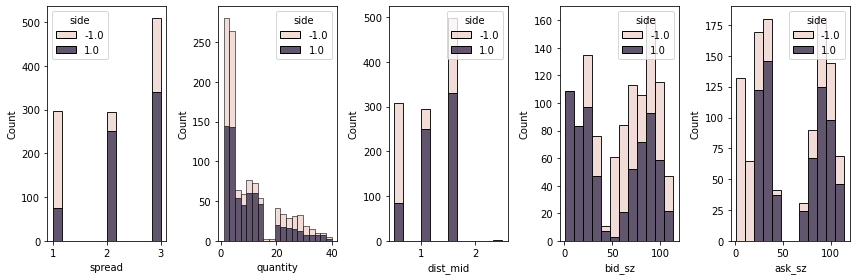

In [39]:
for sym in SYMBOLS:
    trades = hist_trades[sym]
    trades['spread'] = trades['ask']-trades['bid']
    trades['dist_mid'] = np.abs(trades['mid_price']-trades['price'])
    
    print(sym)
    f, ax = plt.subplots(1, 5, figsize=(12,4))
    for i, col in enumerate(['spread','quantity', 'dist_mid', 'bid_sz','ask_sz']):
        sns.histplot(x=col, data=trades, ax=ax[i], hue='side',multiple='stack')
    plt.tight_layout()

COCONUTS
PINA_COLADAS


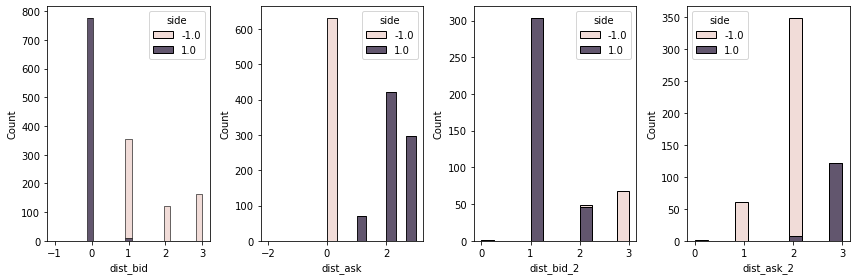

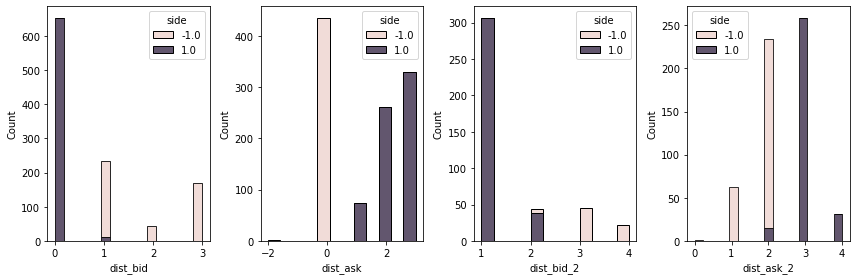

In [40]:
for sym in SYMBOLS:
    trades = hist_trades[sym]
    trades['dist_bid'] = trades['price']-trades['bid']
    trades['dist_ask'] = trades['ask']-trades['price']
    
    trades['dist_bid_2'] = trades['price']-trades['bid_2']
    trades['dist_ask_2'] = trades['ask_2']-trades['price']
    
    print(sym)
    f, ax = plt.subplots(1, 4, figsize=(12,4))
    for i, col in enumerate(['dist_bid','dist_ask','dist_bid_2','dist_ask_2']):
        sns.histplot(x=col, data=trades, ax=ax[i], hue='side',multiple='stack')
    plt.tight_layout()

## Trade Toxicity

In [37]:
def trade_analysis(orders):
    # For historical trades
    orders['px_bid_dist'] = orders['price'] - orders['bid']
    orders['px_ask_dist'] = orders['price'] - orders['ask']
    
    for t in FUTURE_TIMES:
        orders[f'tox_{t}'] = orders['side']*(orders[f'fpx_{t}']+orders['mid_price']-orders['price'])
        orders[f'pnl_{t}'] = orders['quantity']*orders[f'tox_{t}']
        orders[f'fill_revert_{t}'] = np.sign(orders[f'pnl_{t}'])
    
    return

In [41]:
FUTURE_TIMES

[1, 2, 3, 4, 5, 10, 25, 50, 100, 200, 500]

In [45]:
for sym in SYMBOLS:
    trades = hist_trades[sym]
    quote = hist_quotes[sym]
    
    trade_quote = trades.merge(quote, how='left',on=['symbol','timestamp'], suffixes=('','_q'))
    trade_analysis(trade_quote)
    trade_quote.drop(trade_quote.filter(regex='_q$').columns, axis=1, inplace=True)
    
    tox_summary = trade_quote.groupby(['symbol','side'])[['tox_1','tox_10','tox_25','tox_50','tox_100','tox_500','quantity']].mean()
    display(tox_summary)

tox_1    tox_10    tox_25    tox_50   tox_100   tox_500  \
symbol   side                                                               
COCONUTS -1.0 -1.084507 -1.008048 -1.048290 -1.136318 -1.108149 -0.340543   
          1.0 -0.140726 -0.069390 -0.295071 -0.121271 -0.158885  0.076524   

                quantity  
symbol   side             
COCONUTS -1.0  24.272636  
          1.0  24.649805

tox_1    tox_10    tox_25    tox_50   tox_100   tox_500  \
symbol       side                                                               
PINA_COLADAS -1.0 -1.085629 -1.304192 -1.378443 -1.297605 -0.700000  0.769461   
              1.0 -0.240706 -0.268587 -0.316914 -0.763011  0.226766 -3.191450   

                    quantity  
symbol       side             
PINA_COLADAS -1.0  10.071856  
              1.0  10.256506

In [48]:
trade_quote.head()[['timestamp','price','bid','ask','side','tox_10']]

,timestamp,price,bid,ask,side,tox_10
0,7200,15015.0,15012.0,15015.0,1.0,-3.5
1,8100,15011.0,15011.0,15013.0,-1.0,-2.5
2,10300,15027.0,15027.0,15030.0,-1.0,-2.0
3,14700,15025.0,15025.0,15027.0,-1.0,-7.0
4,16700,15036.0,15036.0,15038.0,-1.0,10.0


# Pairs Analysis

In [10]:
sym1, sym2 = 'COCONUTS','PINA_COLADAS'

quote1 = hist_quotes[sym1].drop(columns='day').copy()
quote2 = hist_quotes[sym2].drop(columns='day').copy()

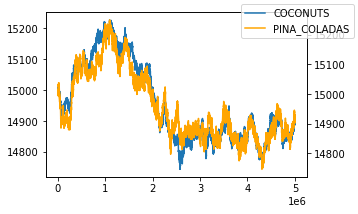

In [11]:
col = 'fair_price'
quote1['fair_price'] = quote1['mid_price']*15/8
quote2['fair_price'] = quote2['mid_price']

f, ax = plt.subplots(figsize=(5,3))
ax.plot('timestamp',col, data=quote1, label=sym1)
ax2 = ax.twinx()
ax2.plot('timestamp',col, data=quote2, label=sym2, color='orange')
f.legend()
plt.tight_layout()

In [126]:
signal.loc[np.abs(signal) < 2].describe()

count    38905.000000
mean         0.103070
std          1.010713
min         -2.000000
25%         -0.661861
50%          0.148295
75%          0.912397
max          2.000000
Name: signal, dtype: float64

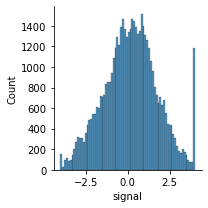

In [122]:
sns.displot(np.clip(signal, -4,4),height=3)


count    50000.000000
mean         0.214924
std          1.667466
min         -4.530814
25%         -0.844556
50%          0.216750
75%          1.217694
max          6.290638
Name: signal, dtype: float64


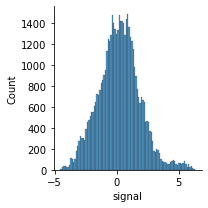

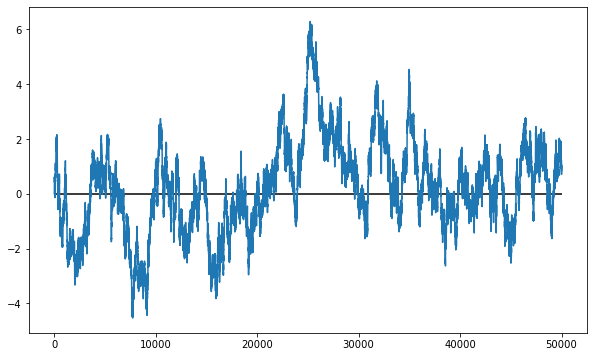

In [134]:
px_ratio = 400*(quote2['mid_price']/quote1['mid_price']-15/8)
signal = px_ratio.rename('signal')
# signal -= 0.2
print(signal.describe())
sns.displot(signal,height=3)

f, ax = plt.subplots(figsize=(10,6))
ax.plot(signal)
ax.hlines(y=0, xmin=signal.index.min(), xmax=signal.index.max(),color='black')

count    50000.000000
mean         4.145700
std         33.227461
min        -91.437500
25%        -16.875000
50%          4.312500
75%         24.187500
max        124.562500
Name: mid_price, dtype: float64


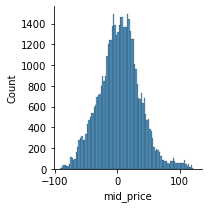

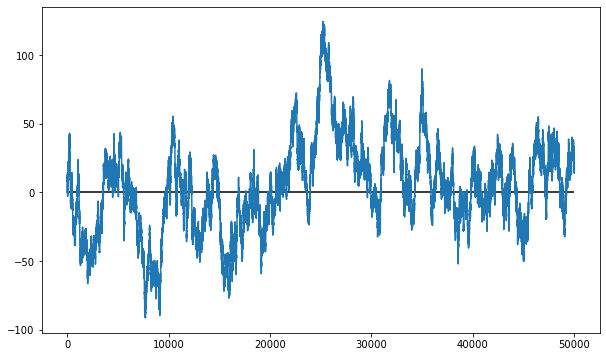

In [90]:
columns = ['timestamp', 'mid_price', 'bid', 'bid_sz','ask', 'ask_sz','fair_v1', 'bid_2', 'bid_sz_2','ask_2', 'ask_sz_2']

pair_data = quote1[columns].merge(quote2[columns], on=['timestamp'], suffixes=('_'+sym1,'_'+sym2))
pair_data['signal'] = -400*(pair_data['mid_price_PINA_COLADAS']/pair_data['mid_price_COCONUTS']-15/8)

In [ ]:
# quote1 = hist_quotes[sym1].drop(columns='day').copy()
# quote2 = hist_quotes[sym2].drop(columns='day').copy()

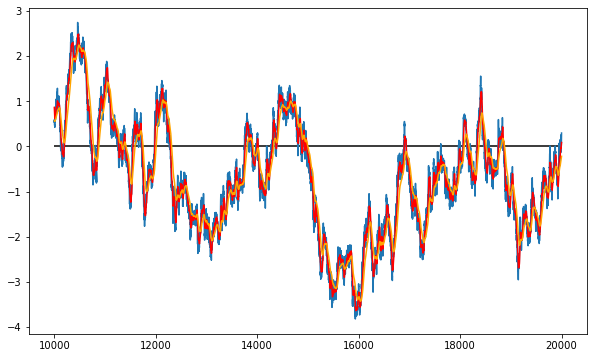

In [92]:
px_ratio = 400*(quote2['mid_price']/quote1['mid_price']-15/8)
signal = px_ratio.rename('signal')
signal_lagged1 = signal.ewm(10, min_periods=0).mean()
signal_lagged2 = signal.ewm(50, min_periods=0).mean()

# signal = signal.ewm(5, min_periods=0).mean()

# signal_lagged1 = signal.rolling(20, min_periods=0).mean()
# signal_lagged2 = signal.rolling(50, min_periods=0).mean()
start, end = 10000, 20000

f, ax = plt.subplots(figsize=(10,6))
ax.plot(signal[start:end])
ax.plot(signal_lagged1[start:end], color='red')
ax.plot(signal_lagged2[start:end], color='orange')

ax.hlines(y=0, xmin=start, xmax=end,color='black')

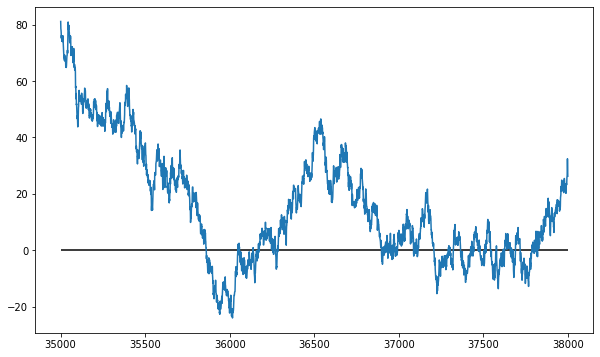

In [163]:
spread = (quote2['mid_price']-15/8*quote1['mid_price'])
# start, end = 1000, 1250
f, ax = plt.subplots(figsize=(10,6))
ax.plot(spread[start:end])
ax.hlines(y=0, xmin=start, xmax=end,color='black')

# Backtest Analysis

## Load

COCONUTS: PnL=28736.0 | Trades=303.0 | MarketVol=8883 | Volume Filled=12429.0 | POV=0.58 | Shares/Step=1.24 | PnL/Share=2.312
PINA_COLADAS: PnL=47191.0 | Trades=311.0 | MarketVol=2548 | Volume Filled=6688.0 | POV=0.72 | Shares/Step=0.669 | PnL/Share=7.056
Total PnL=75927.0


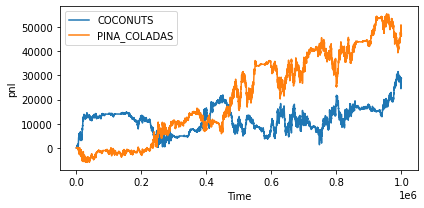

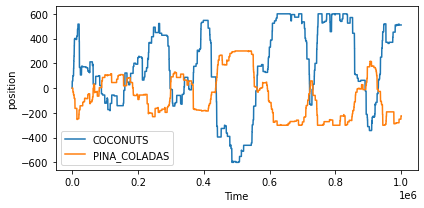

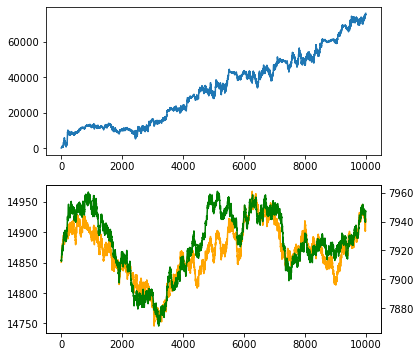

In [129]:
log_file = "backtest_logs/backtest.log"
# log_file = "round3_logs/6bb4c7ed-464c-4d08-941c-5e9a07587e0e.log"
# log_file = "round3_logs/" + "086a8d22-ca6f-4fac-bb71-5c53245c09f1.log"

# log_file = "round4_logs/" + "26851424-784c-4c91-a593-7ddb4384245b.log"

# # log_file = "round4_logs/" + "a66ed35d-6077-42c1-943e-6eaf0a3a0547.log"
# # log_file = "round4_logs/" + "a1d19ceb-b02e-4847-a62f-942f85bb5317.log"
# log_file = "round4_logs/" + "26862413-6caf-4835-8b5b-940330295216.log"

dfs = load_data_from_log(log_file, True)
trading_simulation_summary(dfs)

f, ax = plt.subplots(2, figsize=(6,6))
pair_pnl = dfs['positions']['COCONUTS']['pnl'] + dfs['positions']['PINA_COLADAS']['pnl']
pair_pnl.plot(ax=ax[0])
ax[1].plot(dfs['quote']['PINA_COLADAS']['mid_price'], color='orange')
ax[1].twinx().plot(dfs['quote']['COCONUTS']['mid_price'], color='green')

In [106]:
sym1, sym2 = 'COCONUTS','PINA_COLADAS'
backtest_quote1 = dfs['quote'][sym1]
backtest_quote2 = dfs['quote'][sym2]

count    10000.000000
mean        -1.737341
std          1.560081
min         -6.290638
25%         -2.609719
50%         -1.482138
75%         -0.630676
max          1.555556
Name: signal, dtype: float64


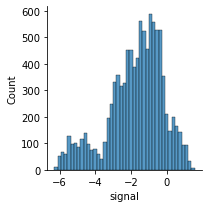

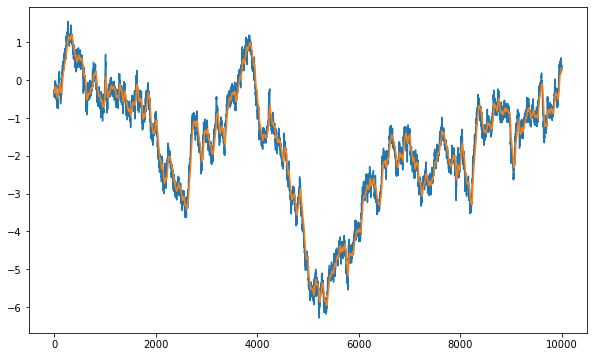

In [107]:
px_ratio = -400*(backtest_quote2['mid_price']/backtest_quote1['mid_price']-15/8)
signal = px_ratio.rename('signal')
lag = signal.ewm(20, min_periods=0).mean()

print(signal.describe())
sns.displot(signal,height=3)

f, ax = plt.subplots(figsize=(10,6))
ax.plot(signal)
ax.plot(lag)

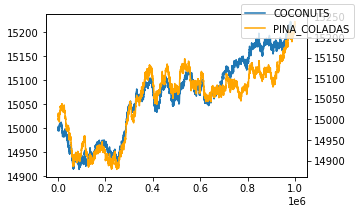

In [58]:
col = 'fair_price'
backtest_quote1['fair_price'] = backtest_quote1['mid_price']*15/8
backtest_quote2['fair_price'] = backtest_quote2['mid_price']

f, ax = plt.subplots(figsize=(5,3))
ax.plot('timestamp',col, data=backtest_quote1, label=sym1)
ax2 = ax.twinx()
ax2.plot('timestamp',col, data=backtest_quote2, label=sym2, color='orange')
f.legend()
plt.tight_layout()

## Trades

In [99]:
pair_fills, pair_missed_fills = [], []
for sym in SYMBOLS:
    market_trades = dfs['market_trades'][sym]
    orders = dfs['orders'][sym]
    quote = dfs['order_depths'][sym].copy()
    fills, missed_fills = get_orders_fills(market_trades, orders, quote)
    pair_fills.append(fills)
    pair_missed_fills.append(missed_fills)
pair_fills = pd.concat(pair_fills)
pair_missed_fills = pd.concat(pair_missed_fills)

In [100]:
pair_fills.groupby(['symbol','side','note'])[['pnl_1','pnl_10','pnl_50','pnl_100','pnl_500','fill_qty']].sum()

pnl_1  pnl_10  pnl_50  pnl_100  pnl_500  fill_qty
symbol       side note                                                    
COCONUTS     -1   P0   -1084.0 -1606.0   959.5   1027.0   4332.5    1279.0
                  P1      29.5     2.0    93.0    251.0    442.0      32.0
                  X0   -4238.5 -4514.5  -280.0   7147.0  -5553.5    4304.0
              1   P0     616.0   211.5  3629.0   3214.0    744.5    2509.0
                  P1     109.5   -46.0   962.5   1687.5   1601.0     171.0
                  X0   -1058.0 -2408.5 -1188.5  -3934.0  31356.0    3429.0
PINA_COLADAS -1   P0    -252.5  -293.0 -2127.5   -661.0  -3848.0     569.0
                  P1     -11.0  -126.5  -177.5    -13.0   -308.5      19.0
                  X0   -2392.0  2336.5  4228.5   5955.5 -26363.0    2601.0
              1   P0     711.0  2344.5  1970.0   2801.5    526.5    1147.0
                  P1      59.5   396.5    29.0     95.0   1438.0      92.0
                  X0    1255.5 -1533.0 -5706.5  -6319.5  13287.0    1709.0

In [101]:
pair_missed_fills.groupby(['symbol','side_algo','note'])[['quantity_algo','quantity_mkt']].mean()

quantity_algo  quantity_mkt
symbol       side_algo note                             
COCONUTS     -1        P0        39.000000     25.806122
                       P1        39.000000     25.744186
                       X0        87.000000      7.500000
              1        P0        37.741007     26.485612
                       P1        38.764706     20.352941
PINA_COLADAS -1        P0        18.201794      9.645740
                       P1        19.000000      8.230769
                       X0        30.000000      4.000000
              1        P0        18.936652      9.375566
                       P1        19.000000      9.114286